In [118]:
import h5py as h5
import imageio as io
import matplotlib.pyplot as plt
%matplotlib inline
import os
import numpy as np
from skimage.filters import gaussian

In [119]:
def gauss_intensity_rot(xx,yy,x0,y0,sigma_x,sigma_y,rot,height):
    gauss = lambda x,s: np.exp(-(x**2/(s**2)))
    new_xx=(xx-x0)*np.cos(rot)+(yy-y0)*np.sin(rot)
    new_yy=(xx-x0)*np.sin(rot)-(yy-y0)*np.cos(rot)
    return gauss(new_xx,sigma_x)*gauss(new_yy,sigma_y)*height+np.random.normal(0.05,0.02,size=np.shape(xx))
def ellipse(xx,yy,x0,y0,ax1,ax2,rot):
    x_,y_ = (xx-x0),(yy-y0)
    c,s=np.cos(rot),np.sin(rot)
    return (x_*c+y_*s)**2/ax1**2+(x_*s-y_*c)**2/ax2**2 < 1
def rotate(seg,ang):
    x=seg[0]*np.cos(ang)-seg[1]*np.sin(ang)
    y=seg[1]*np.cos(ang)+seg[0]*np.sin(ang)
    return np.array([x,y])
def make_axon(tortuousity,n_seg,seg_length):
    segment=np.array([seg_length,0]).reshape(2,1)
    init_angle=np.random.rand()*2*np.pi
    segment=rotate(segment,init_angle)
    next_angles=np.random.normal(0,tortuousity,size=n_seg-1)
    next_segments=rotate(segment,next_angles)
    return np.cumsum(np.hstack((segment,next_segments)),axis=1).astype(int)#add all segments up to make the axon
def live_neuron_oval(xx,yy,x0,y0):
    ab=np.random.randint(36,81) #simialr to a 6x6 or 9x9 area
    ax1=np.random.randint(int(0.7*np.sqrt(ab)),int(1.3*np.sqrt(ab))) #oval range
    ax2=ab/ax1
    rot=np.random.rand()*np.pi #rotate it
    body=ellipse(xx,yy,x0,y0,ax1,ax2,rot)
    if ax1>ax2:
        hinge1=[(x0+ax1)*np.cos(rot),(x0+ax1)*np.sin(rot)]
        hinge2=[(x0-ax1)*np.cos(rot),(x0-ax1)*np.sin(rot)]
    else:
        hinge1=[x0+ax2*np.cos(rot+np.pi/2.),y0+ax2*np.sin(rot+np.pi/2.)]
        hinge2=[x0-ax2*np.cos(rot+np.pi/2.),y0-ax2*np.sin(rot+np.pi/2.)]
    axon_layer=np.zeros((256,256))

    for i in range(np.random.randint(0,4)):
        p=np.random.rand()
        if p>0.5:
            hinge=hinge1
        else:
            hinge=hinge2
        ax,ay=hinge[1],hinge[0]
        axon=make_axon(tortuousity=0.4,n_seg=np.random.randint(15,80),seg_length=1)+np.array([int(ax),int(ay)]).reshape(2,1)
        axon=np.clip(axon,0,255)
        axon_layer[axon[0,:],axon[1,:]]=True
    axon_layer[body]=False #cover the axons with the cell body
    final=np.zeros((256,256,2))
    final[:,:,1]=body
    final[:,:,0]=axon_layer
    return final.astype(bool),ax1,ax2,rot
def put_live_neurons(synthetic_image):
    for i in range(np.random.randint(1,15)):
        tmp_a=np.zeros((256,256))
        tmp_b=np.zeros((256,256))
        center=np.random.randint(255),np.random.randint(255)
        axbody,ax1,ax2,rot=live_neuron_oval(xx,yy,center[0],center[1])
        jitter_x_I=-ax2/3.+2/3.*np.random.rand()*ax2
        jitter_y_I=ax1/3.+2/3.*np.random.rand()*ax1
        sigma_xI=1.2*ax1
        sigma_yI=1.2*ax2
        I=0.7+0.3*np.random.rand()
        intensity=gauss_intensity_rot(xx,yy,center[0]+jitter_x_I,center[1]+jitter_y_I,sigma_xI,sigma_yI,rot,I)# gauss halo coloring

        tmp_a[axbody[:,:,0]]=np.random.normal(.9+0.5*np.random.rand(),0.1,size=(256,256))[axbody[:,:,0]] #axons
        final_intensity=np.max(np.vstack((synthetic[axbody[:,:,1],1],intensity[axbody[:,:,1]])),axis=0)
        tmp_b[axbody[:,:,1]]=final_intensity #bodies
        synthetic[axbody[:,:,1],1]=tmp_b[axbody[:,:,1]]
        synthetic[:,:,0]+=gaussian(tmp_a,sigma=1.2,mode='wrap')
def put_dead_neurons(synthetic,cell_radius):
    for i in range(15,50):
        tmp=np.zeros((256,256))
        center=np.random.randint(255),np.random.randint(255)
        jitter_x_I=-cell_radius/3.+2/3.*np.random.rand()*cell_radius
        jitter_y_I=-cell_radius/3.+2/3.*np.random.rand()*cell_radius
        sigma_xI=0.8*cell_radius
        sigma_yI=0.8*cell_radius
        I=0.7+0.3*np.random.rand()
        intensity=gauss_intensity_rot(xx,yy,center[0]+jitter_x_I,center[1]+jitter_y_I,sigma_xI,sigma_yI,0,I)# gauss halo coloring
        cell_mask=ellipse(xx,yy,center[0],center[1],cell_radius,cell_radius,0)
        if np.max(synthetic[cell_mask,1])<0.5:
            tmp[cell_mask]=intensity[cell_mask]
            synthetic[:,:,2]+=tmp

In [120]:
xx,yy=np.meshgrid(np.arange(256),np.arange(256))

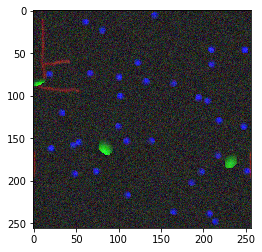

In [121]:
plt.imshow((np.clip(synthetic,0,1)*255).astype(np.uint8))

In [122]:
N_images=50
dataname='brightfield_neurons'
train_name='synthetic'
directory='../Data/'+dataname+'/'+train_name+'/'
if not os.path.exists(directory):
    os.makedirs(directory)

In [123]:
for i in range(N_images):
    name=directory+str(i).zfill(5)+'.png'
    synthetic=np.random.normal(0.15,0.07,size=(256,256,3))
    put_live_neurons(synthetic)
    put_dead_neurons(synthetic,4.5)
    image=(np.clip(synthetic,0,1)*255).astype(np.uint8)
    io.imsave(name,image)
    if i%50==0:
        print i,

0


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in divide
  after removing the cwd from sys.path.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


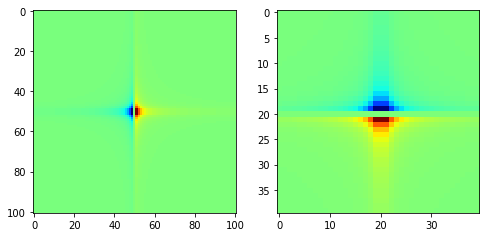

In [124]:
# Create the 1/x masks to decode position
ls            = np.linspace(-50,50,101)
grid_X,grid_Y = np.meshgrid(ls,ls)
grid_R        = (0.75*5/np.abs(grid_X)) * np.sign(grid_X)
grid_R[:,50]  = grid_R[:,51]
grid_R        = np.maximum(np.minimum(grid_R,3),-3)
maskX         = grid_R * np.abs(grid_R.T)
maskX[:,50]   = 0.
maskY         = maskX.T
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(maskX,cmap='jet')
plt.subplot(1,2,2)
a = 20
plt.imshow(maskY[50-a:50+a,50-a:50+a],cmap='jet')
plt.show()

In [125]:
from scipy.signal import convolve2d,fftconvolve
def colored_neurons():
    n_cells=np.random.randint(1,15)
    cell_mask=np.zeros((256,256,n_cells))
    centers=np.zeros((n_cells,2))
    colored_neurons=np.zeros((256,256,3))
    cell_centers=np.zeros((256,256))
    for i in range(n_cells):

        center=np.random.randint(255),np.random.randint(255)
        centers[i,:]=center
        axbody,ax1,ax2,rot=live_neuron_oval(xx,yy,center[0],center[1])
        jitter_x_I=-ax2/3.+2/3.*np.random.rand()*ax2
        jitter_y_I=ax1/3.+2/3.*np.random.rand()*ax1
        sigma_xI=1.2*ax1
        sigma_yI=1.2*ax2
        I=0.7+0.3*np.random.rand()
        intensity=gauss_intensity_rot(xx,yy,center[0]+jitter_x_I,center[1]+jitter_y_I,sigma_xI,sigma_yI,rot,I)# gauss halo coloring
        cell_mask[axbody[:,:,1],i]=intensity[axbody[:,:,1]]
    cell_centers[centers[:,0].astype(int),centers[:,1].astype(int)]=1
    chan_red      = np.tanh(fftconvolve(cell_centers,maskX,mode='same')*5)/2.+0.5
    chan_blue     = np.tanh(fftconvolve(cell_centers,maskY,mode='same')*5)/2.+0.5
    chan_green    = 1.-chan_blue
        
    for i in range(len(centers)):
        colored_neurons[:,:,0] += chan_red[int(centers[i,0]),int(centers[i,1])] * cell_mask[:,:,i]
        colored_neurons[:,:,1] += chan_green[int(centers[i,0]),int(centers[i,1])] * cell_mask[:,:,i]
        colored_neurons[:,:,2] += chan_blue[int(centers[i,0]),int(centers[i,1])] * cell_mask[:,:,i] 
    noise=np.random.normal(loc=0.1,scale=0.05,size=(256,256,3))
    colored_neurons[colored_neurons==0]=noise[colored_neurons==0]
    return (np.clip(colored_neurons,0,1)*255).astype(np.uint8)

In [110]:
coln=colored_neurons()
plt.imshow(coln)

In [126]:
N_images=50
dataname='cycled_neurons_colored'
train_name='synthetic'
directory='../Data/'+dataname+'/'+train_name+'/'
if not os.path.exists(directory):
    os.makedirs(directory)

In [128]:
for i in range(N_images):
    name=directory+str(i).zfill(5)+'.png'
    image=colored_neurons()
    io.imsave(name,image)
    if i%50==0:
        print i,

0
